In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [50]:
#we are using merged dataset that is downloaded from other jupyter notebook
merged = pd.read_csv('/kaggle/input/merged-data/merged_data (1).csv')

In [30]:
merged.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ID,Date,Element,Data_Value,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSNFLAG,HCNFLAG,WMOID,x,y,x_group,y_group,xy_group,hash
0,USW00094889,2014-11-12,TMAX,22,42.2228,-83.7444,255.7,MI,ANN ARBOR MUNI AP,NaN,NaN,NaN,-6.895857e+06,4.694968e+06,-6961077.395912573 to -6863743.967196207,4621600.621334892 to 4718934.050051258,"-6961077.395912573 to -6863743.967196207, 4621...",fb441e62df2d58994928907a91895ec62c2c42e6cd075c...
1,USC00208972,2009-04-29,TMIN,56,42.4356,-83.7831,276.1,MI,WHITMORE LAKE 1NW,NaN,NaN,NaN,-6.875744e+06,4.718630e+06,-6961077.395912573 to -6863743.967196207,4621600.621334892 to 4718934.050051258,"-6961077.395912573 to -6863743.967196207, 4621...",fb441e62df2d58994928907a91895ec62c2c42e6cd075c...
2,USC00200032,2008-05-26,TMAX,278,41.9164,-84.0158,231.6,MI,ADRIAN 2 NNE,NaN,HCN,NaN,-6.951679e+06,4.660898e+06,-6961077.395912573 to -6863743.967196207,4621600.621334892 to 4718934.050051258,"-6961077.395912573 to -6863743.967196207, 4621...",fb441e62df2d58994928907a91895ec62c2c42e6cd075c...
3,USC00205563,2005-11-11,TMAX,139,41.9069,-83.4158,178.6,MI,MONROE,NaN,NaN,NaN,-6.903061e+06,4.659841e+06,-6961077.395912573 to -6863743.967196207,4621600.621334892 to 4718934.050051258,"-6961077.395912573 to -6863743.967196207, 4621...",fb441e62df2d58994928907a91895ec62c2c42e6cd075c...
4,USC00200230,2014-02-27,TMAX,-106,42.2947,-83.7108,274.3,MI,ANN ARBOR U OF MICH,NaN,HCN,NaN,-6.885235e+06,4.702963e+06,-6961077.395912573 to -6863743.967196207,4621600.621334892 to 4718934.050051258,"-6961077.395912573 to -6863743.967196207, 4621...",fb441e62df2d58994928907a91895ec62c2c42e6cd075c...


In [31]:
import numpy as np

df= pd.read_csv('/kaggle/input/binsize/BinSize.csv')
# If 'HCN' is present in the HCNFLAG column, return 'HCN', otherwise return '0'
df['HCN_FLAG'] = np.where(df['HCNFLAG'] == 'HCN', 1, 0)

# If 'GSN' is present in the GSNFLAG column, return 1, otherwise return 0
df['GSN_FLAG'] = np.where(df['GSNFLAG'] == 'GSN', 1, 0)


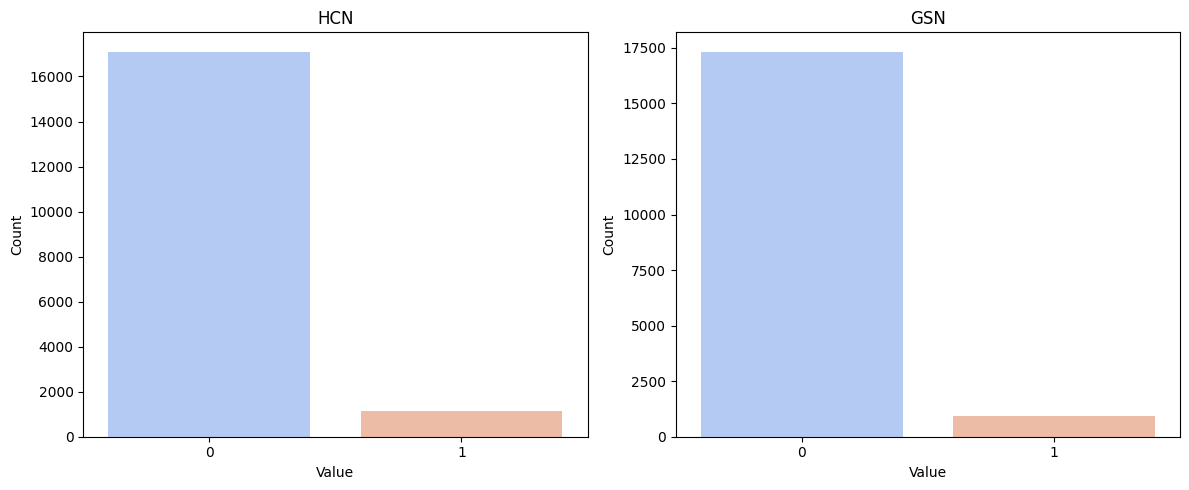

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

hcn_counts = df["HCN_FLAG"].value_counts()
gsn_counts = df["GSN_FLAG"].value_counts()

# Create a figure
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot HCN_FLAG
sns.barplot(x=hcn_counts.index, y=hcn_counts.values, ax=ax[0], palette="coolwarm")
ax[0].set_title("HCN")
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Count")


# Plot GSN_FLAG
sns.barplot(x=gsn_counts.index, y=gsn_counts.values, ax=ax[1], palette="coolwarm")
ax[1].set_title("GSN")
ax[1].set_xlabel("Value")
ax[1].set_ylabel("Count")

# Show the plot
plt.tight_layout()
plt.show()

We are going to create a model which predict the temperature based on the some parameters like Elevation,Month and temperature.

In [51]:
# Convert Date to datetime
merged['Date'] = pd.to_datetime(merged['Date'], format='%Y-%m-%d')
merged['Year'] = merged['Date'].dt.year
merged['Month'] = merged['Date'].dt.month
merged['Day'] = merged['Date'].dt.day  # Extracts the day
merged['Temperature'] = merged['Data_Value'] / 10
merged['Is_TMAX'] = (merged['Element'] == 'TMAX').astype(int)

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numerical_features = merged[['LATITUDE', 'LONGITUDE']]
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_features.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_features.values, i)
                   for i in range(len(numerical_features.columns))]
print(vif_data)

     feature           VIF
0   LATITUDE  45313.336445
1  LONGITUDE  45313.336445


High correlation between Latitude and Longitude .Multicollinearity is there so we should remove Longitude.Also we'll remove some columns which doesnt provide anything to our model

In [53]:
merged.columns

Index(['ID', 'Date', 'Element', 'Data_Value', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'STATE', 'NAME', 'GSNFLAG', 'HCNFLAG', 'WMOID', 'x', 'y',
       'x_group', 'y_group', 'xy_group', 'hash', 'Year', 'Month', 'Day',
       'Temperature', 'Is_TMAX'],
      dtype='object')

In [54]:
columns_to_remove = ['Data_Value','ID','Date','LONGITUDE','STATE', 'NAME', 'GSNFLAG', 'HCNFLAG', 'WMOID', 'x', 'y',
       'x_group', 'y_group', 'xy_group','hash','Year', 'Day','Element']
merged = merged.drop(columns=columns_to_remove)

In [55]:
merged.head()

,LATITUDE,ELEVATION,Month,Temperature,Is_TMAX
0,42.2228,255.7,11,2.2,1
1,42.4356,276.1,4,5.6,0
2,41.9164,231.6,5,27.8,1
3,41.9069,178.6,11,13.9,1
4,42.2947,274.3,2,-10.6,1


In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numerical_features = merged[['LATITUDE', 'ELEVATION','Temperature']]
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_features.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_features.values, i)
                   for i in range(len(numerical_features.columns))]
print(vif_data)

       feature        VIF
0     LATITUDE  42.245158
1    ELEVATION  41.350917
2  Temperature   1.597956


Multicolinearity between latitude and elevation ,we'll keep latitude only

In [57]:
columns_to_remove = ["ELEVATION"]
merged = merged.drop(columns=columns_to_remove)

In [58]:
merged.head()

,LATITUDE,Month,Temperature,Is_TMAX
0,42.2228,11,2.2,1
1,42.4356,4,5.6,0
2,41.9164,5,27.8,1
3,41.9069,11,13.9,1
4,42.2947,2,-10.6,1


In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merged["LATITUDE"] = scaler.fit_transform(merged[["LATITUDE"]])


In [61]:
merged.head(3)

,LATITUDE,Month,Temperature,Is_TMAX
0,0.602777,11,2.2,1
1,1.635856,4,5.6,0
2,-0.884700,5,27.8,1


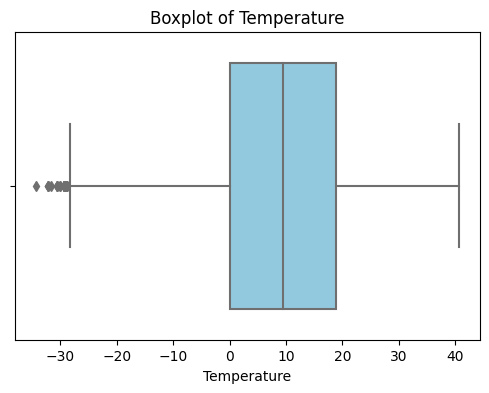

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.boxplot(x=merged["Temperature"], color="skyblue")
plt.title("Boxplot of Temperature")
plt.show()

In [64]:
import pandas as pd
from scipy.stats import skew

temperature_skew = skew(merged["Temperature"])
print(f"Skewness of Temperature: {temperature_skew}")


Skewness of Temperature: -0.04543797826509342


Since the skewness is close to zero, we can conclude that the distribution is approximately normal.

In [65]:


# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

merged['Season'] = merged['Month'].apply(get_season)


In [68]:
merged.head()

,LATITUDE,Temperature,Is_TMAX,Season
0,0.602777,2.2,1,Fall
1,1.635856,5.6,0,Spring
2,-0.884700,27.8,1,Spring
3,-0.930820,13.9,1,Fall
4,0.951830,-10.6,1,Winter


In [67]:
columns_to_remove = ["Month"]
merged = merged.drop(columns=columns_to_remove)

In [69]:
season_mapping = {"Winter": 3, "Spring": 2, "Summer": 1, "Fall": 0}
merged["Seasons"] = merged["Season"].map(season_mapping)

In [70]:
merged.head()

,LATITUDE,Temperature,Is_TMAX,Season,Seasons
0,0.602777,2.2,1,Fall,0
1,1.635856,5.6,0,Spring,2
2,-0.884700,27.8,1,Spring,2
3,-0.930820,13.9,1,Fall,0
4,0.951830,-10.6,1,Winter,3


In [71]:
columns_to_remove = ["Season"]
merged = merged.drop(columns=columns_to_remove)

In [72]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numerical_features = merged[['LATITUDE', 'Is_TMAX','Seasons']]
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_features.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_features.values, i)
                   for i in range(len(numerical_features.columns))]
print(vif_data)

    feature       VIF
0  LATITUDE  1.000002
1   Is_TMAX  1.477461
2   Seasons  1.477462


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = merged[["LATITUDE", "Is_TMAX", "Seasons"]]  
y = merged["Temperature"]  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)


Model Coefficients: [-0.33428156 11.35147214 -5.55113112]
Model Intercept: 12.101207957538684


In [85]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred = model.predict(X_test)

# Metrics Calculation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)


Mean Absolute Error (MAE): 7.5801801200919146
Mean Squared Error (MSE): 81.5784490764117
Root Mean Squared Error (RMSE): 9.032078890067984
R-squared (R²): 0.46310786101094514


In [87]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Predictions
y_pred_ridge = ridge_model.predict(X_test)

# Metrics Calculation
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Metrics:")
print("MAE:", ridge_mae)
print("MSE:", ridge_mse)
print("RMSE:", ridge_rmse)
print("R-squared:", ridge_r2)


Ridge Regression Metrics:
MAE: 7.580177094885093
MSE: 81.57842629740848
RMSE: 9.032077629062346
R-squared: 0.4631080109263689


In [88]:
from xgboost import XGBRegressor

# Train XGBoost Regressor
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Metrics Calculation
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("\n📌 XGBoost Regression Metrics:")
print("MAE:", xgb_mae)
print("MSE:", xgb_mse)
print("RMSE:", xgb_rmse)
print("R-squared:", xgb_r2)



📌 XGBoost Regression Metrics:
MAE: 5.046592900805428
MSE: 41.5201699541483
RMSE: 6.443614665244058
R-squared: 0.7267433604064749


Since our data is not linear, Linear Regression struggled with underfitting, leading to poor performance. However, by using XGBoost, the model significantly reduced bias and achieved a much better accuracy of 72%.